# Predicting heart disease

In this notebook I will attempt to use Python libraries to create a model that predicts if a patient has heart disease.

I will take the following approach:
1. Define the problem
2. The data
3. Define the evaluation metric that means success
4. Decide which features of the given data should be focused on
5. Create the model
6. Experimentation with the model and data

## 1. Problem definition

"Given clinical parameters of a patient can the model predict whether or not they have heart disease" 

Since this sounds like a classification problem we will be using the Scikit-Learn algorithm to help us decide on the estimator

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

## 2. The data

This dataset comes from Kaggle ( https://www.kaggle.com/datasets/cherngs/heart-disease-cleveland-uci ) and it is based on the Cleveland data available in the UCI ML repository. Some changes in descriptions have been made by the author of this dataset

## 3. Evaluation

The goal is to reach around 95% accuracy at predicting whether or not the patient has heart disease 

## 4. Picking data features

Creating a way to easily get information about the data

**Create data dictionary** 

* age: age in years
* sex: sex (1 = male; 0 = female)
* cp: chest pain type

    -- Value 0: typical angina

    -- Value 1: atypical angina

    -- Value 2: non-anginal pain
  
    -- Value 3: asymptomatic
* trestbps: resting blood pressure (in mm Hg on admission to the hospital)
* chol: serum cholestoral in mg/dl
* fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
* restecg: resting electrocardiographic results

    -- Value 0: normal

    -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)

    -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
* thalach: maximum heart rate achieved
* exang: exercise induced angina (1 = yes; 0 = no)
* oldpeak = ST depression induced by exercise relative to rest
* slope: the slope of the peak exercise ST segment

    -- Value 0: upsloping

    -- Value 1: flat

    -- Value 2: downsloping
* ca: number of major vessels (0-3) colored by flourosopy
* thal: 0 = normal; 1 = fixed defect; 2 = reversable defect 
* condition: 0 = no disease, 1 = disease

In [345]:
# Getting the tools ready 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
# Pandas, Numpy and Matplotlib will be used for data analysis and manipulation

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.exceptions import ConvergenceWarning

import warnings

warnings.filterwarnings("ignore")

# Scikit-Learn will be used in order to create, fit and evaluate the model. 
# We are importing the models in accordance to Scikit-Learn algorithm cheat-sheet

## Loading the data

In [2]:
# Bite me Kaggle!
try:
    df = pd.read_csv("heart_cleveland_upload.csv")
except:
    df = pd.read_csv("/kaggle/input/heart-disease-cleveland-uci/heart_cleveland_upload.csv")
df.shape

(297, 14)

## Data exploration (EDA)

1. What question(s) are we trying to answer
2. What kind of data do we have, is it of one type or not
3. What's missing from the data and how to deal with it
4. Where are the outliers and how do we deal with them
5. How can we add, change, remove features to get more from the data provided


In [3]:
df.rename(columns={"condition":"target"}, inplace=True)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [4]:
df["target"].value_counts(), print(f"There are {df['target'].value_counts().sum()} values in the target column")

There are 297 values in the target column


(0    160
 1    137
 Name: target, dtype: int64,
 None)

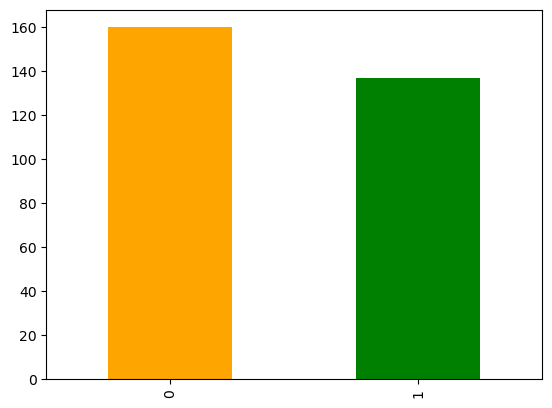

In [5]:
df["target"].value_counts().plot(kind="bar", color=["orange", "green"]);

This graph informs us that this dataset is almost "balanced" - there are pretty much as many positive values as there are negative ones

In [6]:
df.info(), df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    int64  
 1   sex       297 non-null    int64  
 2   cp        297 non-null    int64  
 3   trestbps  297 non-null    int64  
 4   chol      297 non-null    int64  
 5   fbs       297 non-null    int64  
 6   restecg   297 non-null    int64  
 7   thalach   297 non-null    int64  
 8   exang     297 non-null    int64  
 9   oldpeak   297 non-null    float64
 10  slope     297 non-null    int64  
 11  ca        297 non-null    int64  
 12  thal      297 non-null    int64  
 13  target    297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


(None,
 age         0
 sex         0
 cp          0
 trestbps    0
 chol        0
 fbs         0
 restecg     0
 thalach     0
 exang       0
 oldpeak     0
 slope       0
 ca          0
 thal        0
 target      0
 dtype: int64)

There are no missing values in any of the columns making our job a little easier, since we don't have to deal with removing or supplementing any of it

### Heart Disease Frequency according to Sex

In [7]:
df["sex"].value_counts()

1    201
0     96
Name: sex, dtype: int64

Text(0, 0.5, 'Amounts')

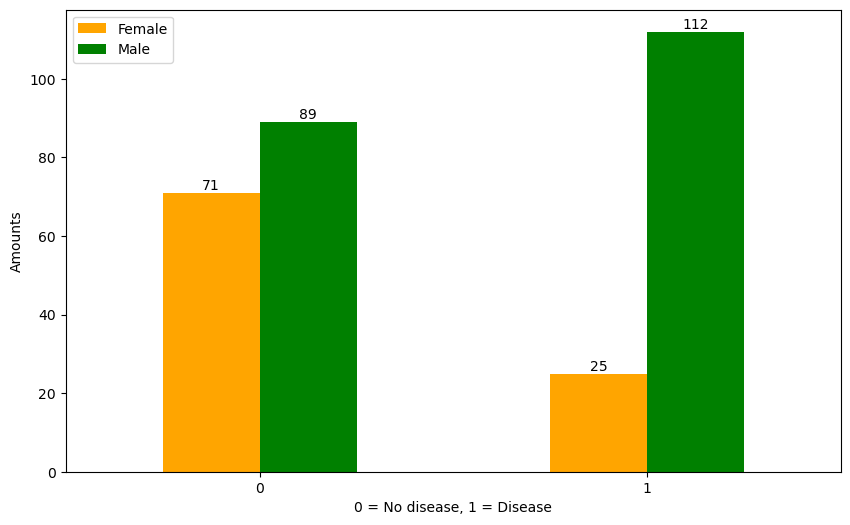

In [8]:
# Compare target column with sex column
fig, ax = plt.subplots()
pd.crosstab(df["target"], df["sex"]).plot(kind="bar", figsize=(10, 6), color=["orange", "green"], ax=ax)
for container in ax.containers:
    ax.bar_label(container)
ax.legend(["Female", "Male"])
plt.xticks(rotation=0)
plt.xlabel("0 = No disease, 1 = Disease")
plt.ylabel("Amounts")

### Age vs. Maximum Heart Rate for Heart Disease

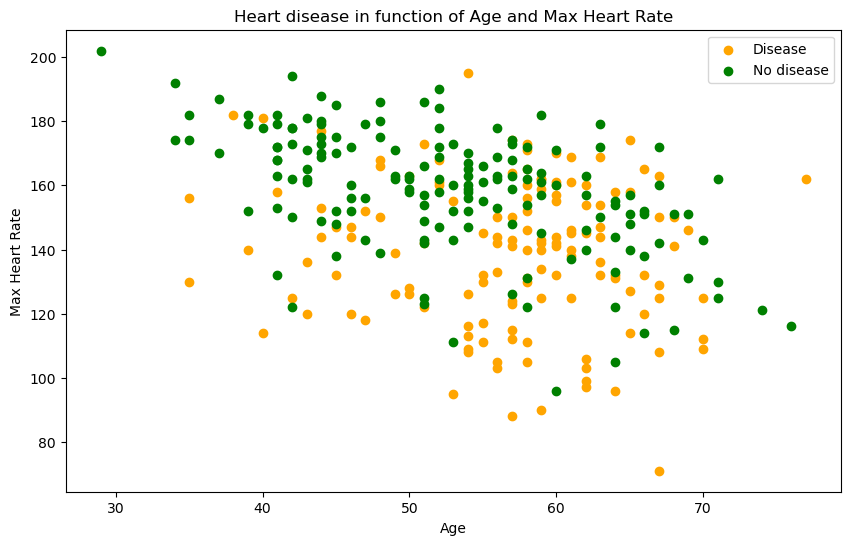

In [9]:
plt.figure(figsize=(10, 6))

plt.scatter(df["age"][df["target"]==1], df["thalach"][df["target"]==1], c="orange")
plt.scatter(df["age"][df["target"]==0], df["thalach"][df["target"]==0], c="green")
plt.title("Heart disease in function of Age and Max Heart Rate")
plt.xlabel("Age")
plt.ylabel("Max Heart Rate")
plt.legend(["Disease", "No disease"]);

We can observe a trend showing that with older age the prevalence of heart diseases grows

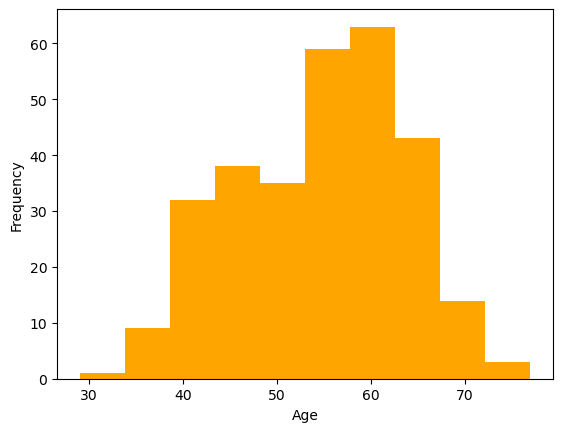

In [10]:
df["age"].plot(kind="hist", color="orange")
plt.xlabel("Age");

This graph confirms our suspicions - as the patients grow older the more of them suffer from heart disease. There is a peak around the 60 years mark, which ten starts to drop off. Grimly, we can understand it as a natural occurence, since if someone suffers from a heart disease they are less likely to grow older (according to CDC 1 in 5 deaths are caused by heart diseases)

### Heart Disease Frequency per Chest Pain type

cp: chest pain type

    -- Value 0: typical angina

    -- Value 1: atypical angina

    -- Value 2: non-anginal pain
  
    -- Value 3: asymptomatic

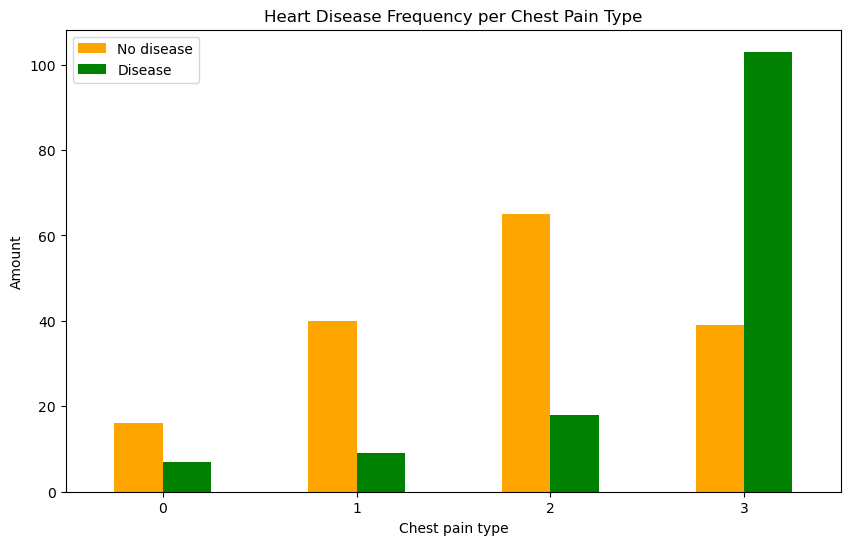

In [11]:
pd.crosstab(df["cp"], df["target"]).plot(kind="bar", figsize=(10, 6), color=["orange", "green"])
plt.title("Heart Disease Frequency per Chest Pain Type")
plt.xlabel("Chest pain type")
plt.ylabel("Amount")
plt.legend(["No disease", "Disease"])
plt.xticks(rotation=0);
# I believe that either the original dataset was wrong 
# or that this one is somehow inverted and 0 means that the patient has heart disease...

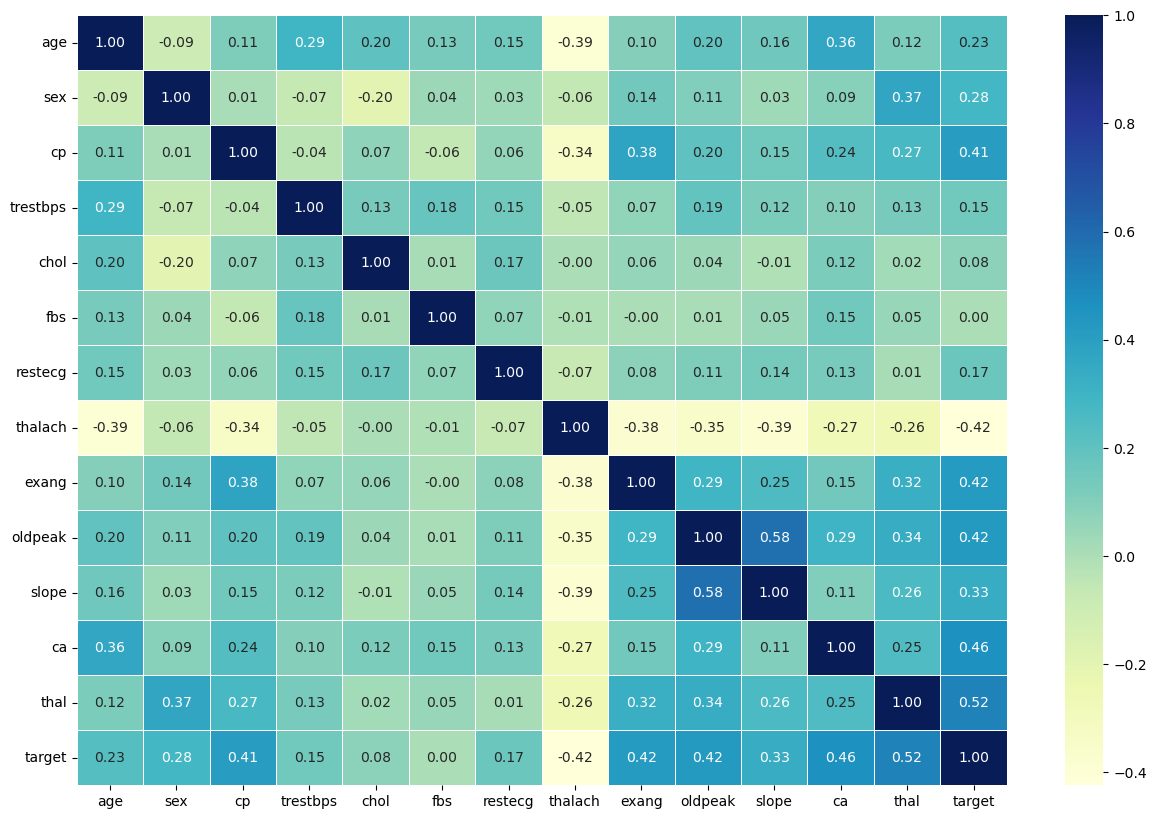

In [12]:
# Making a correlation matrix
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_matrix, annot=True, linewidths=0.5, fmt=".2f", cmap="YlGnBu")
plt.yticks(rotation=0);

To learn more about correlation matrices I suggest reeading <a ahref="https://www.statisticshowto.com/correlation-matrix/">this</a>. 

In short - the values in squares (correlation coefficients) tell us how every single feature correlates with all the other ones. The further the value is from 0 there is a higher correlation between two features. 

If the value is positive, we have a positive correlation (If feature's A value increases feature's B value increases as well), when the coefficient is negative we have negative correlation (if feature's A value decreases feature's B value increases and the other way around). 

## 5. Modelling

# Round 1 - "Lightning Round"

In [13]:
# Splitting data into X and y
X = df.drop("target", axis=1)
y = df["target"]

# Splitting the data into training and test sets
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

We are going to try 3 different machine learning models
1.  `LogisticRegression()`
2.  `KNeighborsClassifier()`
3.  `RandomForrestClassifier()` 

In [14]:
# Create a models dictionary

models = {
    "LogisticRegression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "RandomForestClassifier": RandomForestClassifier()
}

# Create a function which fits models and scores them

def fit_and_score(models, X_train, X_test, y_train, y_test):
    """This function fits models from the models dictionary and then evaluates them, returning each models score
    models: dictionary consisting on all models that will be used
    X_train: training data (no labels)
    X_test: testing data(no labels)
    y_train: training labels
    y_test: testing lables"""

    # set random seed so the results are reproducible
    np.random.seed(42)
    
    model_scores = {}
    for name, model in models.items():
        # It's time to fit the models with our training data and lables
        model.fit(X_train, y_train)
        # Here we append the model_scores dict with the scores for each model
        model_scores[name] = model.score(X_test, y_test)

    return model_scores


In [15]:
model_scores = fit_and_score(
    models= models,
    X_train= X_train,
    X_test= X_test,
    y_train= y_train,
    y_test= y_test
)

model_scores

{'LogisticRegression': 0.8,
 'KNN': 0.5888888888888889,
 'RandomForestClassifier': 0.8111111111111111}

## Model Comparison

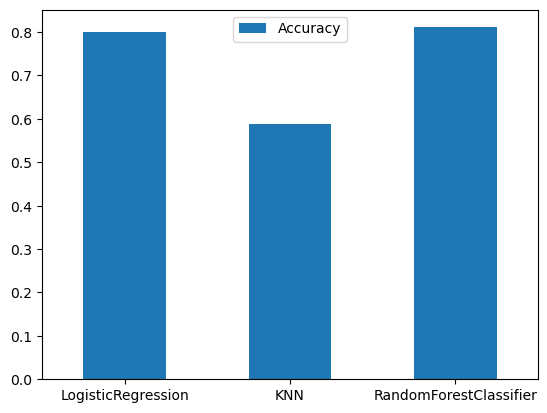

In [16]:
model_compare = pd.DataFrame(model_scores, index=["Accuracy"])
model_compare.T.plot.bar()
plt.xticks(rotation=0);

Now that we have accuracy of the base models it's time to work on tuning the most promising ones

We'll focus on the following:
1. Hyperparameter tuning
2. Feature importance
3. Confusion matrix
4. Cross-validation
5. Precision
6. Recall
7. F1 score
8. Classification report
9. Area Under Curve (AUC)

## Hyperparameter Tuning 

In [17]:
# Starting with KNN Classifier

train_scores = []
test_scores = []

# Create a list of different values for n_neighbors
neighbors = range(1, 21)

# Setup KNN instance
knn = KNeighborsClassifier()

# Loop through different neighbors and fit different models 
for i in neighbors:
    knn.set_params(n_neighbors=i)
    knn.fit(X_train, y_train)

    # Update train_scores and test_scores lists 
    train_scores.append(knn.score(X_train, y_train))
    test_scores.append(knn.score(X_test, y_test))


In [18]:
train_scores

[1.0,
 0.782608695652174,
 0.782608695652174,
 0.7536231884057971,
 0.748792270531401,
 0.7584541062801933,
 0.7439613526570048,
 0.7391304347826086,
 0.714975845410628,
 0.7198067632850241,
 0.714975845410628,
 0.7246376811594203,
 0.7053140096618358,
 0.7294685990338164,
 0.7294685990338164,
 0.714975845410628,
 0.7101449275362319,
 0.7294685990338164,
 0.714975845410628,
 0.7198067632850241]

In [19]:
test_scores

[0.5444444444444444,
 0.5888888888888889,
 0.6,
 0.5555555555555556,
 0.5888888888888889,
 0.5777777777777777,
 0.6222222222222222,
 0.5888888888888889,
 0.6333333333333333,
 0.6333333333333333,
 0.6666666666666666,
 0.6222222222222222,
 0.6333333333333333,
 0.6555555555555556,
 0.6333333333333333,
 0.6555555555555556,
 0.6444444444444445,
 0.6777777777777778,
 0.6666666666666666,
 0.6444444444444445]

Maximum KNN score on test data is 67.78%


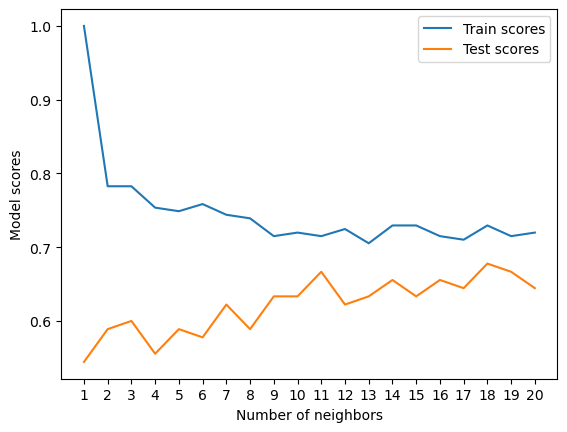

In [20]:
plt.plot(neighbors, train_scores, label="Train scores")
plt.plot(neighbors, test_scores, label="Test scores")
plt.xticks(np.arange(1, 21, 1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model scores")
plt.legend()

print(f"Maximum KNN score on test data is {max(test_scores)*100:.2f}%")

The results made me decide on not pursuing the `KNeighborsClassifier()`

## Hyperparameter tuning with RandomizedSearchCV

I'll focus on tuning:
 * `LogisticRegression()`
 * `RandomForestClassifier()`

In [21]:
# Starting with a grid of parameters for LogisticRegression()
log_reg_grid = {
    "C": np.logspace(-4, 4, 30),
    "solver": ["liblinear", "lbfgs"]
}

# Now hyperparameter grid for RandomForestClassifier()
rand_for_grid = {
    "n_estimators": np.arange(10, 1000, 50),
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(1, 20, 2)
}

rs_scores = {}

In [22]:
# Starting with LogisticRegression

np.random.seed(42)

rs_log_reg = RandomizedSearchCV(
    estimator= LogisticRegression(), 
    param_distributions= log_reg_grid,
    cv= 5,
    n_iter= 20,
    verbose= True
)

# Fitting random hyperparameter search model for LogisticRegression

rs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                                        'solver': ['liblinear', 'lbfgs']},
                   verbose=True)

In [23]:
# Let's see what are the best params for this RandomSearchCV
rs_log_reg.best_params_

{'solver': 'lbfgs', 'C': 2.592943797404667}

In [24]:
rs_scores["LogisticRegression"] = rs_log_reg.score(X_test, y_test)

In [25]:
# Now it's time to tune RandomForestClassifier

np.random.seed(42)

rs_rand_for = RandomizedSearchCV(
    estimator= RandomForestClassifier(),
    param_distributions= rand_for_grid,
    cv= 5,
    n_iter= 20,
    verbose= True
)

rs_rand_for.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [26]:
# And again, let's see the best parameters for this model
rs_rand_for.best_params_

{'n_estimators': 460,
 'min_samples_split': 6,
 'min_samples_leaf': 9,
 'max_depth': None}

In [27]:
rs_scores["RandomForestClassifier"] = rs_rand_for.score(X_test, y_test)

In [28]:
print(f"Default hyperparameter scores: {model_scores}\n\n RandomizedSearchCV scores: {rs_scores}")

Default hyperparameter scores: {'LogisticRegression': 0.8, 'KNN': 0.5888888888888889, 'RandomForestClassifier': 0.8111111111111111}

 RandomizedSearchCV scores: {'LogisticRegression': 0.7888888888888889, 'RandomForestClassifier': 0.8111111111111111}


Based on the best params we got these scores - LogisticRegression fares worse than on default settings, RandomForestClassifier did exactly as well on tuned and untuned hyperparameters

## Hyperparameter tuning using GridSearchCV

Now we will give both of those models a chance and compare the scores

In [29]:
gs_scores = {}

gs_log_reg = GridSearchCV(
    estimator= LogisticRegression(),
    param_grid= log_reg_grid,
    cv=5,
    verbose= True
)

gs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                         'solver': ['liblinear', 'lbfgs']},
             verbose=True)

In [30]:
# Again, we are checking for the best parameters out of all possible fits
gs_log_reg.best_params_

{'C': 0.05736152510448681, 'solver': 'liblinear'}

In [31]:
gs_scores["LogisticRegression"] = gs_log_reg.score(X_test, y_test)

For GridSearchCV to work on RandomForestClassifier we have to edit the param_grid, since in it's current state it would have to go through about 36000 different fits

In [32]:
rand_for_grid

{'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
        660, 710, 760, 810, 860, 910, 960]),
 'max_depth': [None, 3, 5, 10],
 'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
 'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19])}

In [33]:
gs_rand_for_grid = {
    "n_estimators": np.arange(250, 700, 50),
    "max_depth": [None, 3, 5],
    "min_samples_split": np.arange(5, 15, 2),
    "min_samples_leaf": np.arange(4, 20, 2)
}

In [34]:
# Changes made to the hyperparameters grid result in only 5400 fits, which is much more manageable 
# On my computer the grid search took about 16 minutes
# I think it's time to get a cup of coffee or tea and take a break

gs_rand_for = GridSearchCV(
    estimator= RandomForestClassifier(),
    param_grid= gs_rand_for_grid,
    cv= 5,
    verbose= True
)

gs_rand_for.fit(X_train, y_train)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 3, 5],
                         'min_samples_leaf': array([ 4,  6,  8, 10, 12, 14, 16, 18]),
                         'min_samples_split': array([ 5,  7,  9, 11, 13]),
                         'n_estimators': array([250, 300, 350, 400, 450, 500, 550, 600, 650])},
             verbose=True)

In [35]:
# Checking the best parameters from this grid search
gs_rand_for.best_params_

{'max_depth': 3,
 'min_samples_leaf': 18,
 'min_samples_split': 11,
 'n_estimators': 350}

In [36]:
gs_scores["RandomForestClassifier"] = gs_rand_for.score(X_test, y_test)

In [37]:
print(f"Default hyperparameter scores: {model_scores}\n\n GridSearchCV scores: {gs_scores}\n\n")
print(f"RandomizedSearchCV hyperparameter scores: {rs_scores}\n\n RandomizedSearchCV scores: {gs_scores}")

Default hyperparameter scores: {'LogisticRegression': 0.8, 'KNN': 0.5888888888888889, 'RandomForestClassifier': 0.8111111111111111}

 GridSearchCV scores: {'LogisticRegression': 0.7666666666666667, 'RandomForestClassifier': 0.7777777777777778}


RandomizedSearchCV hyperparameter scores: {'LogisticRegression': 0.7888888888888889, 'RandomForestClassifier': 0.8111111111111111}

 RandomizedSearchCV scores: {'LogisticRegression': 0.7666666666666667, 'RandomForestClassifier': 0.7777777777777778}


Unexpectedly in this case both models did worse than on both the default and RandomizedSearchCV settings. We'll get back to that later, after going through the whole workflow.

## Evaluting our tuned machine leargning models

* ROC Curve and AUC score
* Confusion matrix
* Classification report
* Precision
* Recall
* F1-score

It would be best to use cross-validation whenever possible. We will evaluate the `gs_log_reg` and the `rs_rand_for` models.

In [38]:
# We start of by making predictions for the Logistic Regression and the RandomForestClassifier
y_log_reg_preds = gs_log_reg.predict_proba(X_test)[::,1]
y_rand_for_preds = rs_rand_for.predict_proba(X_test)[::,1]
evaluated_models = {
    "LogisticRegression": gs_log_reg, 
    "RandomForestClassifier": rs_rand_for
}

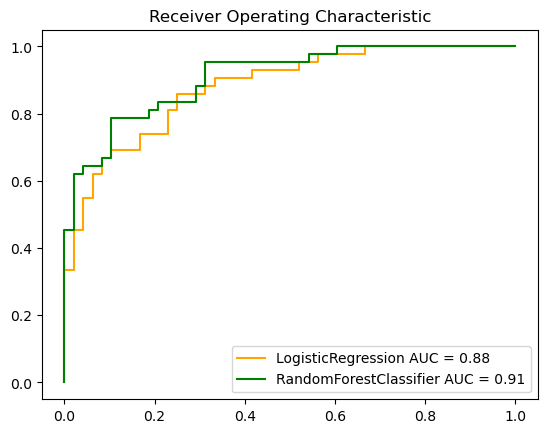

In [39]:
# Plotting the ROC Curves and calculating the AUC metrics
lr_fpr, lr_tpr, lr_threshold = roc_curve(y_test, y_log_reg_preds)
rfc_fpr, rfc_tpr, rfc_threshold = roc_curve(y_test, y_rand_for_preds)
log_reg_roc_auc = auc(lr_fpr, lr_tpr)
rand_for_roc_auc = auc(rfc_fpr, rfc_tpr)


fig, ax = plt.subplots()
plt.title("Receiver Operating Characteristic")
plt.plot(lr_fpr, lr_tpr, label="LogisticRegression AUC = %0.2f"% log_reg_roc_auc, color="orange")
plt.plot(rfc_fpr, rfc_tpr, label="RandomForestClassifier AUC = %0.2f"% rand_for_roc_auc, color="green")
plt.legend(loc= "lower right");



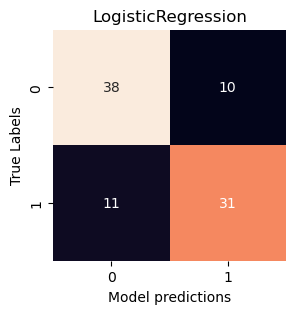

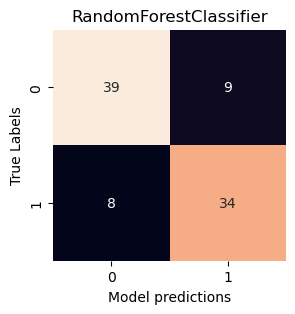

In [40]:
# Now we visualize the confusion matrices for each model
def plot_conf_mat(y_test, y_preds, name):
    """Plots a confusion matrix using Seaborn's heatmap()"""
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds), annot= True, cbar= False)
    plt.title(name)
    plt.xlabel("Model predictions")
    plt.ylabel("True Labels")


for name, model in evaluated_models.items():
    plot_conf_mat(y_test, model.predict(X_test), name)


Now that we have ROC curves, AUC metrics and confusion matrices we can focus on classification report as well as cross-validated precision, recall and F1-score

In [41]:
# This classification report is done only on the test data, forward we will attempt to cross-validate precision, recall and F1

for name, model in evaluated_models.items():
    print(f"Classification report for {name}:\n\n{classification_report(y_test, model.predict(X_test))}")

Classification report for LogisticRegression:

              precision    recall  f1-score   support

           0       0.78      0.79      0.78        48
           1       0.76      0.74      0.75        42

    accuracy                           0.77        90
   macro avg       0.77      0.76      0.77        90
weighted avg       0.77      0.77      0.77        90

Classification report for RandomForestClassifier:

              precision    recall  f1-score   support

           0       0.83      0.81      0.82        48
           1       0.79      0.81      0.80        42

    accuracy                           0.81        90
   macro avg       0.81      0.81      0.81        90
weighted avg       0.81      0.81      0.81        90



## Calculate evaluation metrics using cross-validation

We're going to calculate the same metrics as above using `cross_val_score()`

In [42]:
# Recreate new classifiers with the best params that we found before
print(f"LogisticRegression: {gs_log_reg.best_params_}\nRandomForestClassifier: {rs_rand_for.best_params_}")

LogisticRegression: {'C': 0.05736152510448681, 'solver': 'liblinear'}
RandomForestClassifier: {'n_estimators': 460, 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_depth': None}


In [43]:
log_reg_clf = LogisticRegression(
    C= 0.05736152510448681,
    solver= "liblinear"
)

rand_for_clf = RandomForestClassifier(
    n_estimators= 460,
    min_samples_split= 6,
    min_samples_leaf= 9,
    max_depth= None
)

cv_models = ["LogisticRegression", "RandomForestClassifier"]

In [44]:
# Cross-validated accuracies

cv_acc = {
    "LogisticRegression": np.mean(cross_val_score(log_reg_clf, X, y, cv= 5, scoring= "accuracy")),
    "RandomForestClassifier": np.mean(cross_val_score(rand_for_clf, X, y, cv= 5, scoring= "accuracy"))
}
cv_acc 

{'LogisticRegression': 0.8319774011299437,
 'RandomForestClassifier': 0.771186440677966}

Oddily enough, when cross-validated the `LogisticRegression()` model seems to be doing better

In [45]:
# Cross-validated precision

cv_precision = {
    "LogisticRegression": np.mean(cross_val_score(log_reg_clf, X, y, cv= 5, scoring= "precision")),
    "RandomForestClassifier": np.mean(cross_val_score(rand_for_clf, X, y, cv= 5, scoring= "precision"))
}
cv_precision 

{'LogisticRegression': 0.8717492163009405,
 'RandomForestClassifier': 0.8308701594324788}

In [46]:
# Cross-validated recall

cv_recall = {
    "LogisticRegression": np.mean(cross_val_score(log_reg_clf, X, y, cv= 5, scoring= "recall")),
    "RandomForestClassifier": np.mean(cross_val_score(rand_for_clf, X, y, cv= 5, scoring= "recall"))
}
cv_recall 


{'LogisticRegression': 0.7542328042328041,
 'RandomForestClassifier': 0.7261904761904762}

In [47]:
# Cross-validated F1-score

cv_f1 = {
    "LogisticRegression": np.mean(cross_val_score(log_reg_clf, X, y, cv= 5, scoring= "f1")),
    "RandomForestClassifier": np.mean(cross_val_score(rand_for_clf, X, y, cv= 5, scoring= "f1"))
}
cv_f1

{'LogisticRegression': 0.7876874697629415,
 'RandomForestClassifier': 0.7258584320299175}

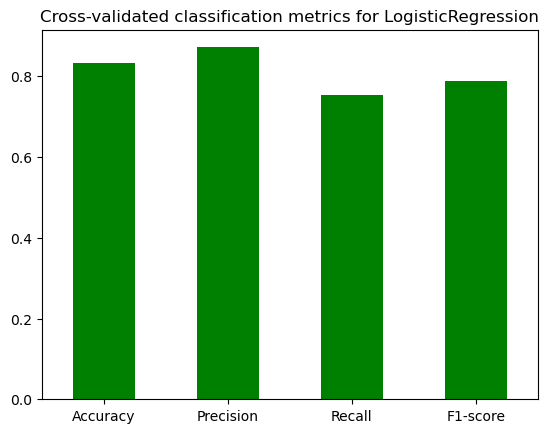

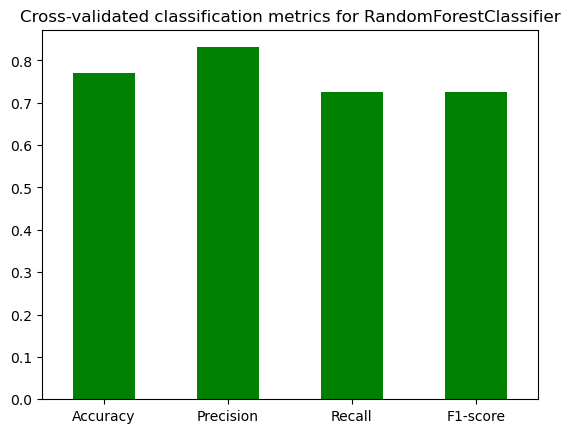

In [48]:
# Visualize cross-validated metrics
cv_metrics = {}
for model in cv_models:
    cv_metrics[model] = pd.DataFrame({
        "Accuracy": cv_acc[model],
        "Precision": cv_precision[model],
        "Recall": cv_recall[model],
        "F1-score": cv_f1[model]}, index=[0])

for name, metric in cv_metrics.items():
    metric.T.plot.bar(title=f"Cross-validated classification metrics for {name}", legend= False, color="green")
    plt.xticks(rotation=0)
    


### Feature Importance

Finding which features were considered the most important. Finding them differs for each model.

Let's start with `LogisticRegression()`

In [49]:
# Let's fit the model that we created - since it has the best parameters found by GridSearchCV

log_reg_clf.fit(X_train, y_train)

LogisticRegression(C=0.05736152510448681, solver='liblinear')

In [50]:
# Now we check coef_ for this model
log_reg_clf.coef_

array([[-0.00869138,  0.40544844,  0.22957008,  0.01457114,  0.00449456,
        -0.09204125,  0.16806197, -0.03309884,  0.1803048 ,  0.37666608,
         0.11863353,  0.55569641,  0.58551854]])

If these values remind you of something it's the correlation matrix from the very beginning of this notebook. The method `coef_` shows us the correlations between each feature and the target values. Let's make it more understandable by putting the names to the values and then creating a bar graph.

In [51]:
# Matching coefs to feature columns
log_reg_feature_dict = dict(zip(df.columns, list(log_reg_clf.coef_[0])))
log_reg_feature_dict

{'age': -0.008691375464541143,
 'sex': 0.40544843996692165,
 'cp': 0.2295700817389926,
 'trestbps': 0.014571139855594297,
 'chol': 0.004494559251056255,
 'fbs': -0.092041247360764,
 'restecg': 0.16806196633679527,
 'thalach': -0.0330988377417638,
 'exang': 0.18030479913450329,
 'oldpeak': 0.3766660789490381,
 'slope': 0.11863352813730361,
 'ca': 0.555696407284894,
 'thal': 0.5855185428105433}

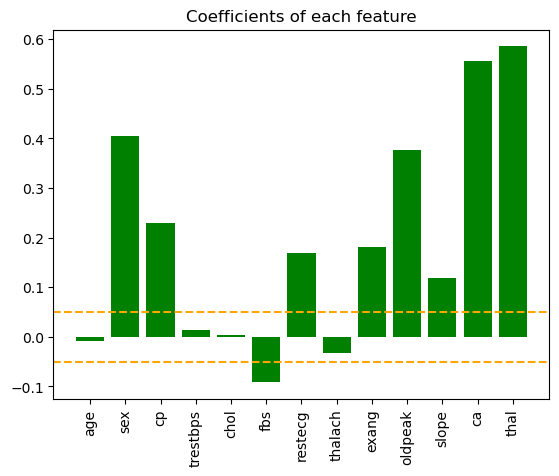

In [52]:
plt.bar(height=list(log_reg_feature_dict.values()), x=list(log_reg_feature_dict.keys()), color="green")
plt.title("Coefficients of each feature")
for y_val in (0.05, -0.05):
    plt.axhline(y=y_val, color="orange", linestyle="--")
plt.xticks(rotation=90);

I arbitrarily decided on creating two cutoff values on this graph (the orange lines going through y= 0.05 and y= -0.05). For the next iteration of the model we might want to either:
- Collect more data with the highest or the lowest coefficients (but since this is a fixed dataset it's not possible)
- Drop the columns with the lowest coefficients (age, trestbps, chol, thalach) 
- Try to combine features together

Now let's focus on the `RandomForestClassifier()` and features considered important by the model

In [53]:
rand_for_clf.fit(X_train, y_train)
rand_for_clf.feature_importances_

array([0.04620649, 0.04991066, 0.0995155 , 0.02876954, 0.02958133,
       0.00094248, 0.01124747, 0.1348663 , 0.06213483, 0.13863245,
       0.04458189, 0.13392741, 0.21968364])

Here again we have values that inform us on how important the features were for the model. These values differ in the way they are measured. Quoting from the <a href="https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#">documentation</a>:
   
    "Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree"

We can deduce that the higher the value the more important the feature is.

In [54]:
rand_for_feature_dict = dict(zip(df.columns, list(rand_for_clf.feature_importances_)))
rand_for_feature_dict

{'age': 0.046206493042568644,
 'sex': 0.04991065948558665,
 'cp': 0.09951549618919422,
 'trestbps': 0.0287695405127354,
 'chol': 0.029581329575555686,
 'fbs': 0.0009424777307779332,
 'restecg': 0.011247467776660837,
 'thalach': 0.13486630417586026,
 'exang': 0.06213483183123633,
 'oldpeak': 0.13863245251449519,
 'slope': 0.044581893030365714,
 'ca': 0.13392741054726423,
 'thal': 0.2196836435876989}

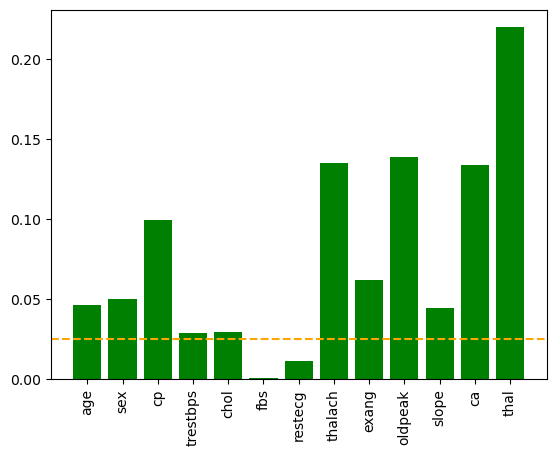

In [55]:
plt.bar(x=list(rand_for_feature_dict.keys()), height=list(rand_for_feature_dict.values()), color="green")
plt.axhline(y=0.025, color="orange", linestyle="--")
plt.xticks(rotation=90);

Here I created a horizontal line at another arbitrary value (y= 0.025). In that case we could do one of the three things I mentioned earlier, for the `LogisticRegression()` model, that is:
- Collect more data with the highest or the lowest importance (but since this is a fixed dataset it's not possible)
- Drop the columns with the lowest importance (fbs, restecg) and think about how we should treat the features that barely made it above the cutoff value (trestbps, chol) 
- Try to combine features together


By now we haven't really hit the evaluation metric that we aimed for in the beginning. In this case it's time for experimentation. 

We can: 
- try new models 
- try to tune current models again (maybe with more hyperparameters or with new values for the currently examined ones). 
- If this was a project that we were collecting data for we could attempt to get more samples

Right now I will focus on going back and tuning hyperparameters for each of the models separately. That will call for lots of research but hopefully will be worth it in the end.

# Round 2 - `LogisticRegression()`

We will start with creating a new X and y variables for this particular model. For testing purposes I will drop the features that turned out to be least important. Googling "can you drop least important features in a dataset" lead me to learn that it is acceptable and can be used in training models. As we stated previously:

    "Drop the columns with the lowest coefficients (age, trestbps, chol, thalach) "

In [56]:
# We drop the unwanted features from our data set, then we check to see if it worked correctly. 
# Once again, we have to add this bit of code to make sure it works on our machines AND on Kaggle
try:
    df_log_reg = pd.read_csv("heart_cleveland_upload.csv")
except:
    df_log_reg = pd.read_csv("/kaggle/input/heart-disease-cleveland-uci/heart_cleveland_upload.csv")

df_log_reg.drop(["age", "trestbps", "chol", "thalach"], axis=1, inplace=True)
df_log_reg.rename(columns={"condition":"target"}, inplace=True)


In [57]:
# We divide our new dataset into X and y specific to this model only

log_reg_X = df_log_reg.drop(["target"], axis=1)
log_reg_y = df_log_reg["target"]

# Then let's split it into training and testing data
log_reg_X_train, log_reg_X_test, log_reg_y_train, log_reg_y_test = train_test_split(log_reg_X, log_reg_y, test_size=0.2)



In [58]:
# Now we instantiate a new LogisticRegression() model, fit it and score it (on the validation set)

log_reg_model = LogisticRegression()
log_reg_model.fit(log_reg_X_train, log_reg_y_train)
log_reg_model.score(log_reg_X_test, log_reg_y_test)


0.85

Interestingly, this time `LogisticRegression()` out of the "box" did better than in Round 1 (We got 0.8 initially). We will go through tuning this model via `RandomizedSearchCV` and `GridSearchCV()` but I will spend more time learning which hyperparameters are the most important to tune, and what values are recommended. 

In [59]:
log_reg_param_grid = {
    "solver": ["lbfgs", "liblinear","newton-cg"],
    "penalty": [None, "l2", "l1", "elasticnet"],
    "warm_start": [True, False],
    "max_iter": list(range(50, 550, 25)),
    "C": [0.01, 0.1, 1.0, 10, 100, 1000]
}

In [60]:
np.random.seed(42)

randsearch_log_reg = RandomizedSearchCV(
    estimator= LogisticRegression(),
    param_distributions= log_reg_param_grid,
    cv= 5,
    n_iter= 100,
    verbose= True
)

randsearch_log_reg.fit(log_reg_X_train, log_reg_y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/aleksanderciesielski/opt/miniconda3/envs/ML-env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
385 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/aleksanderciesielski/opt/miniconda3/envs/ML-env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/aleksanderciesielski/opt/miniconda3/envs/ML-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=100,
                   param_distributions={'C': [0.01, 0.1, 1.0, 10, 100, 1000],
                                        'max_iter': [50, 75, 100, 125, 150, 175,
                                                     200, 225, 250, 275, 300,
                                                     325, 350, 375, 400, 425,
                                                     450, 475, 500, 525],
                                        'penalty': [None, 'l2', 'l1',
                                                    'elasticnet'],
                                        'solver': ['lbfgs', 'liblinear',
                                                   'newton-cg'],
                                        'warm_start': [True, False]},
                   verbose=True)

In [61]:
randsearch_log_reg.score(log_reg_X_test, log_reg_y_test)

0.8666666666666667

In [62]:
randsearch_log_reg.best_params_

{'warm_start': False,
 'solver': 'newton-cg',
 'penalty': 'l2',
 'max_iter': 325,
 'C': 0.1}

After giving the `RandomizedSearchCV()` this parameter grid to work with we got (at least on my machine) a better result than the default `LogisticRegression()` model. It's time to force every combination with `GridSearchCV` but for that we will have to once again tighten the parameter grid, so that the search finishes during our lifetime.

In [63]:
log_reg_param_grid

{'solver': ['lbfgs', 'liblinear', 'newton-cg'],
 'penalty': [None, 'l2', 'l1', 'elasticnet'],
 'warm_start': [True, False],
 'max_iter': [50,
  75,
  100,
  125,
  150,
  175,
  200,
  225,
  250,
  275,
  300,
  325,
  350,
  375,
  400,
  425,
  450,
  475,
  500,
  525],
 'C': [0.01, 0.1, 1.0, 10, 100, 1000]}

In [64]:
c_list = list(map(lambda x: x/10, range(1, 20)))
c_list.extend(list(map(lambda x: x/100, range(1, 20))))
log_reg_param_grid_2 = {
    "solver": ["liblinear", "newton-cg"],
    "penalty": ["l2", "l1"],
    "warm_start": [False, True],
    "max_iter": list(range(125, 300, 25)),
    "C": c_list
}


In [65]:
gridsearch_log_reg = GridSearchCV(
    estimator= LogisticRegression(),
    param_grid=log_reg_param_grid_2,
    cv= 5,
    verbose= True
)

gridsearch_log_reg.fit(log_reg_X_train, log_reg_y_train)

Fitting 5 folds for each of 2128 candidates, totalling 10640 fits


/Users/aleksanderciesielski/opt/miniconda3/envs/ML-env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
2660 fits failed out of a total of 10640.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2660 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/aleksanderciesielski/opt/miniconda3/envs/ML-env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/aleksanderciesielski/opt/miniconda3/envs/ML-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/U

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
                               1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9,
                               0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08,
                               0.09, 0.1, 0.11, ...],
                         'max_iter': [125, 150, 175, 200, 225, 250, 275],
                         'penalty': ['l2', 'l1'],
                         'solver': ['liblinear', 'newton-cg'],
                         'warm_start': [False, True]},
             verbose=True)

In [66]:
gridsearch_log_reg.score(log_reg_X_test, log_reg_y_test)

0.85

In [67]:
gridsearch_log_reg.best_params_

{'C': 0.6,
 'max_iter': 125,
 'penalty': 'l2',
 'solver': 'newton-cg',
 'warm_start': False}

Interestingly the `GridSearchCV()` found a best set of hyperparameters that did worse (on my machine) than the one found by `RandomizedSearchCV`. It did as well as the default model though. The scores are accuracy on test sets. Now lets remind ourselves what other metrics we measured during the first round of tests:

* ROC Curve and AUC score
* Confusion matrix
* Classification report
* Precision
* Recall
* F1-score

And let's go from the top...

In [68]:
evaluated_log_regs = {
    "Default model": log_reg_model,
    "RandomizedSearchCV model": randsearch_log_reg.best_estimator_,
    "GridSearchCV model": gridsearch_log_reg.best_estimator_
}



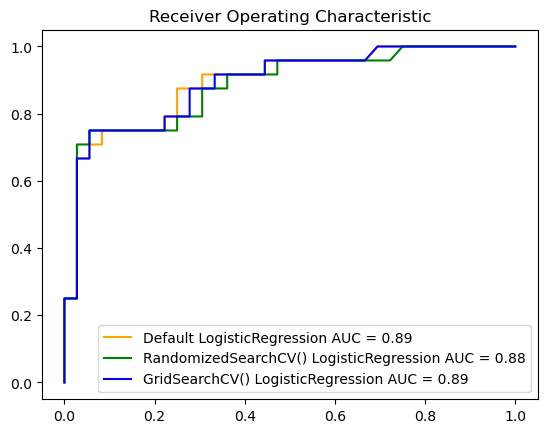

In [69]:
lr_def_fpr, lr_def_tpr, lr_def_threshold = roc_curve(log_reg_y_test, evaluated_log_regs["Default model"].predict_proba(log_reg_X_test)[::,1])
lr_rand_fpr, lr_rand_tpr, lr_rand_threshold = roc_curve(log_reg_y_test, evaluated_log_regs["RandomizedSearchCV model"].predict_proba(log_reg_X_test)[::,1])
lr_grid_fpr, lr_grid_tpr, lr_grid_threshold = roc_curve(log_reg_y_test, evaluated_log_regs["GridSearchCV model"].predict_proba(log_reg_X_test)[::,1])

lr_def_auc = auc(lr_def_fpr, lr_def_tpr)
lr_rand_auc = auc(lr_rand_fpr, lr_rand_tpr)
lr_grid_auc = auc(lr_grid_fpr, lr_grid_tpr)


fig, ax = plt.subplots()
plt.title("Receiver Operating Characteristic")
plt.plot(lr_def_fpr, lr_def_tpr, label="Default LogisticRegression AUC = %0.2f"% lr_def_auc, color="orange")
plt.plot(lr_rand_fpr, lr_rand_tpr, label="RandomizedSearchCV() LogisticRegression AUC = %0.2f"% lr_rand_auc, color="green")
plt.plot(lr_grid_fpr, lr_grid_tpr, label="GridSearchCV() LogisticRegression AUC = %0.2f"% lr_grid_auc, color="blue")
plt.legend(loc= "lower right");

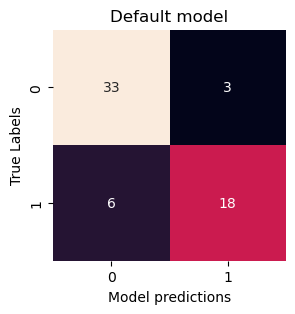

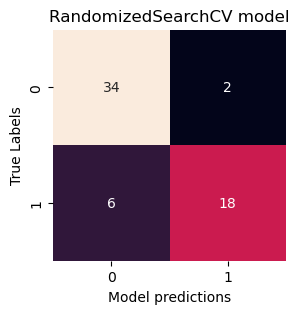

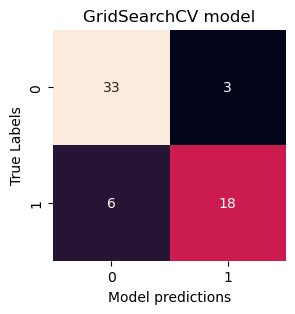

In [70]:
# In order to create confusion matrices for each model we will use an olready created function

for name, model in evaluated_log_regs.items():
    plot_conf_mat(
        y_test= log_reg_y_test,
        y_preds= model.predict(log_reg_X_test),
        name= name
    )

In [71]:
for name, model in evaluated_log_regs.items():
    print(f"Classification report for {name}")
    print(classification_report(log_reg_y_test, model.predict(log_reg_X_test)))

Classification report for Default model
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        36
           1       0.86      0.75      0.80        24

    accuracy                           0.85        60
   macro avg       0.85      0.83      0.84        60
weighted avg       0.85      0.85      0.85        60

Classification report for RandomizedSearchCV model
              precision    recall  f1-score   support

           0       0.85      0.94      0.89        36
           1       0.90      0.75      0.82        24

    accuracy                           0.87        60
   macro avg       0.88      0.85      0.86        60
weighted avg       0.87      0.87      0.86        60

Classification report for GridSearchCV model
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        36
           1       0.86      0.75      0.80        24

    accuracy                           0.85   

Now that we have the completed the evaluations on fitted models let's recreate them with the best parameters and see the results

In [72]:
# Best parameters for the RandomizedSearchCV() version of the model
randsearch_log_reg.best_params_

{'warm_start': False,
 'solver': 'newton-cg',
 'penalty': 'l2',
 'max_iter': 325,
 'C': 0.1}

In [73]:
# Best parameters for the GridSearchCV() version of the model
gridsearch_log_reg.best_params_

{'C': 0.6,
 'max_iter': 125,
 'penalty': 'l2',
 'solver': 'newton-cg',
 'warm_start': False}

In [74]:
lr_def_clf = LogisticRegression()
lr_rand_clf = LogisticRegression(
    warm_start= True,
    solver= "newton-cg",
    penalty= "l2",
    max_iter= 225,
    C= 0.01
)
lr_grid_clf = LogisticRegression(
    warm_start= False,
    solver= "newton-cg",
    penalty= "l2",
    max_iter= 125,
    C= 0.01
)

cv_log_reg = {
    "Default model": lr_def_clf, 
    "RandomizedSearchCV model": lr_rand_clf, 
    "GridSearchCV model": lr_grid_clf
    }


In [270]:
def cross_val_metrics(model, X, y):
    """This function takes a model and measures it's performance through cross validation"""
    cv_results = {}
    cv_results["Accuracy"] = np.mean(cross_val_score(model, X, y, cv= 5, scoring= "accuracy"))
    cv_results["Precision"] = np.mean(cross_val_score(model, X, y, cv=5, scoring="precision"))
    cv_results["Recall"] = np.mean(cross_val_score(model, X, y, cv=5, scoring="recall"))
    cv_results["F1-score"] = np.mean(cross_val_score(model, X, y, cv=5, scoring="f1"))

    return pd.DataFrame(cv_results, index=[0])

cv_lr_scores = {}
for name, model in cv_log_reg.items():
    cv_lr_scores[name] = cross_val_metrics(model, log_reg_X, log_reg_y)

cv_lr_scores    

{'Default model':    Accuracy  Precision    Recall  F1-score
 0  0.811864   0.858002  0.755556  0.738941,
 'RandomizedSearchCV model':    Accuracy  Precision   Recall  F1-score
 0  0.828588   0.861138  0.76164  0.786279,
 'GridSearchCV model':    Accuracy  Precision   Recall  F1-score
 0  0.828588   0.861138  0.76164  0.786279}

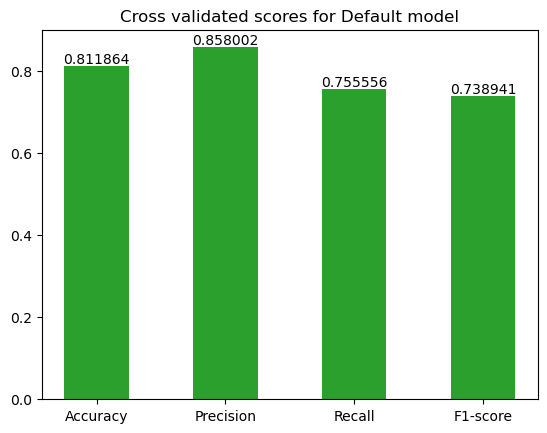

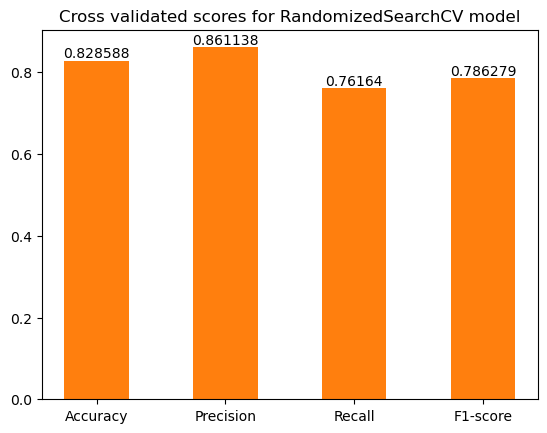

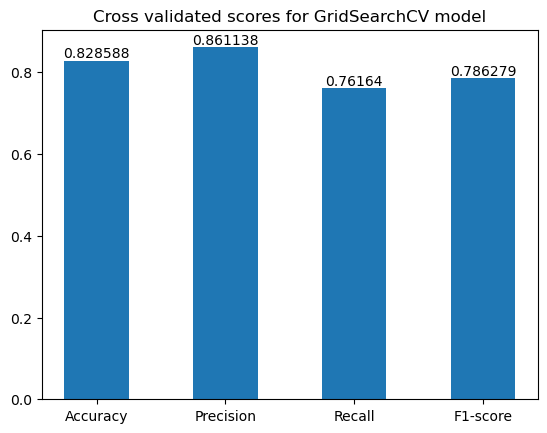

In [271]:
colors = ["tab:green", "tab:orange", "tab:blue"]
idx = 0
for name, metric in cv_lr_scores.items():
    color = colors[idx]
    fig, ax = plt.subplots()
    ax.bar(x=metric.columns, height=metric.values[0], width=0.5, color=colors[idx])
    for container in ax.containers:
        ax.bar_label(container)
    plt.xticks(rotation=0)
    plt.title(f"Cross validated scores for {name}")
    idx +=1 
    

On my machine the cross validated models did as follows - the default model did the worst across all metrics. Both `RandomizedSearchCV()` and `GridSearchCV()` did identically to themselves. 

We are still (again, on my computer) off by around 15% from the target goal of 95% accuracy (which now seems bit unreachable and lowering it to 90% first seems like a better idea) so I think we should try and experiment on the `RandomizedSearchCV()` model by comparing it to the `GridSearchCV()` one and seeing which parameters were different between the two of them, and tuning these particular ones. 

In [77]:
randsearch_log_reg.best_params_

{'warm_start': False,
 'solver': 'newton-cg',
 'penalty': 'l2',
 'max_iter': 325,
 'C': 0.1}

In [78]:
gridsearch_log_reg.best_params_

{'C': 0.6,
 'max_iter': 125,
 'penalty': 'l2',
 'solver': 'newton-cg',
 'warm_start': False}

The differences as we can see are in the "C", "max_iter" and "warm_start" hyperparameters and these three we will tune almost manually. 

God how I hope that on Kaggle and on github (if you're running my notebook from there) these differences actually match the ones you are seeing... Random seed was supposed to keep the notebook constant between machines, but Kaggle surprised me in a sad way.

In [97]:
# Let's start by recreating the model with all the same values as the RandomizedSearchCV() one had, except for the "warm_start"
# Its binary character makes it easy for us to see how it will perform

final_log_reg = RandomizedSearchCV(
    estimator= LogisticRegression(),
    param_distributions={
        "C": [0.1],
        "max_iter": [325],
        "penalty":["l2"],
        "solver": ["newton-cg"],
        "warm_start": [False]
    },
    cv= 5,
    verbose= False
)

final_log_reg.fit(log_reg_X_train, log_reg_y_train)
print(f"RandomizedSearchCV() model: {randsearch_log_reg.score(log_reg_X_test, log_reg_y_test)}")
print(f"Model with changed 'warm_start' : {final_log_reg.score(log_reg_X_test, log_reg_y_test)}")

RandomizedSearchCV() model: 0.8666666666666667
Model with changed 'warm_start' : 0.8666666666666667


/Users/aleksanderciesielski/opt/miniconda3/envs/ML-env/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [80]:
final_log_reg.best_params_

{'warm_start': False,
 'solver': 'newton-cg',
 'penalty': 'l2',
 'max_iter': 125,
 'C': 0.01}

In [98]:
# Cleary "warm_start" set to True or False made no difference
# Now onto "max_iter"

final_log_reg = RandomizedSearchCV(
    estimator= LogisticRegression(),
    param_distributions={
        "C": [0.1],
        "max_iter": list(range(125, 325)),
        "penalty":["l2"],
        "solver": ["newton-cg"],
        "warm_start": [True]
    },
    cv= 5,
    verbose= False
)


final_log_reg.fit(log_reg_X_train, log_reg_y_train)
print(f"Model with 'max_iter' changed : {final_log_reg.score(log_reg_X_test, log_reg_y_test)}")
print(f"RandomizedSearchCV() model: {randsearch_log_reg.score(log_reg_X_test, log_reg_y_test)}")


Model with 'max_iter' changed : 0.8666666666666667
RandomizedSearchCV() model: 0.8666666666666667


In [82]:
final_log_reg.best_params_

{'warm_start': True,
 'solver': 'newton-cg',
 'penalty': 'l2',
 'max_iter': 173,
 'C': 0.01}

In [99]:
# Now let's just do the "C"
final_log_reg = RandomizedSearchCV(
    estimator= LogisticRegression(),
    param_distributions={
        "C": c_list,
        "max_iter": [325],
        "penalty":["l2"],
        "solver": ["newton-cg"],
        "warm_start": [True]
    },
    cv= 5,
    verbose= False
)


final_log_reg.fit(log_reg_X_train, log_reg_y_train)
print(f"Model with 'C' changed : {final_log_reg.score(log_reg_X_test, log_reg_y_test)}")
print(f"RandomizedSearchCV() model: {randsearch_log_reg.score(log_reg_X_test, log_reg_y_test)}")



Model with 'C' changed : 0.8666666666666667
RandomizedSearchCV() model: 0.8666666666666667


In [100]:
final_log_reg.best_params_

{'warm_start': True,
 'solver': 'newton-cg',
 'penalty': 'l2',
 'max_iter': 325,
 'C': 0.1}

Now we see that changing each of them individually didn't really affect the performance by any margin. Let's create <u>one final</u> model that combines all the changed "best" parameters from this little experiment and if it doesn't change all that much we will go on to Round 3.

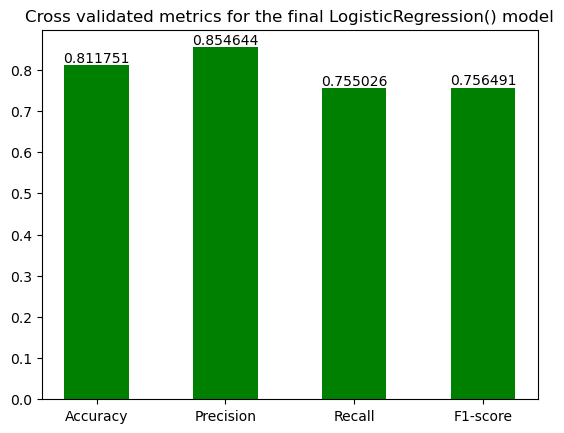

In [101]:
final_log_reg = LogisticRegression(
    C= 0.1,
    max_iter= 325,
    warm_start= False,
    solver= "newton-cg",
    penalty= "l2"
)

final_log_reg_metrics = cross_val_metrics(final_log_reg)

fig, ax = plt.subplots()
ax.bar(x= final_log_reg_metrics.columns, height=final_log_reg_metrics.values[0], color="green", width= 0.5)
plt.title("Cross validated metrics for the final LogisticRegression() model")
for container in ax.containers:
    ax.bar_label(container)


In [102]:
# Let's remind ourselves and compare to the values that the RandomizedSearchCV() model got

cv_lr_scores["RandomizedSearchCV model"]

,Accuracy,Precision,Recall,F1-score
0,0.828588,0.861138,0.76164,0.786279


The "final" model did worse than the default one. 

I think this concludes this Round of finding the model and tuning it. Next up, we will repeat those steps for the `RandomForestClassifier()`.

Final note - I will create a model with preset values that in a previous iteration of this notebook did best and we will see how this model does. Next, I will export the best model as a .joblib file so that it can be used and experimented on 

In [103]:
final_lr_clf = LogisticRegression(
    C= 1.0,
    max_iter= 175,
    solver= "liblinear",
    penalty= "l1",
    warm_start= True
)

final_lr_metrics = cross_val_metrics(final_lr_clf)

final_lr_clf.fit(log_reg_X_train, log_reg_y_train)
final_lr_clf.score(log_reg_X_test, log_reg_y_test)

0.85

In [104]:
# This model did as well in accuracy as the RSCV and GSCV models
# Let's see the classification report and plot the cross validated metrics next

print(classification_report(log_reg_y_test, final_lr_clf.predict(log_reg_X_test)))


              precision    recall  f1-score   support

           0       0.85      0.92      0.88        36
           1       0.86      0.75      0.80        24

    accuracy                           0.85        60
   macro avg       0.85      0.83      0.84        60
weighted avg       0.85      0.85      0.85        60



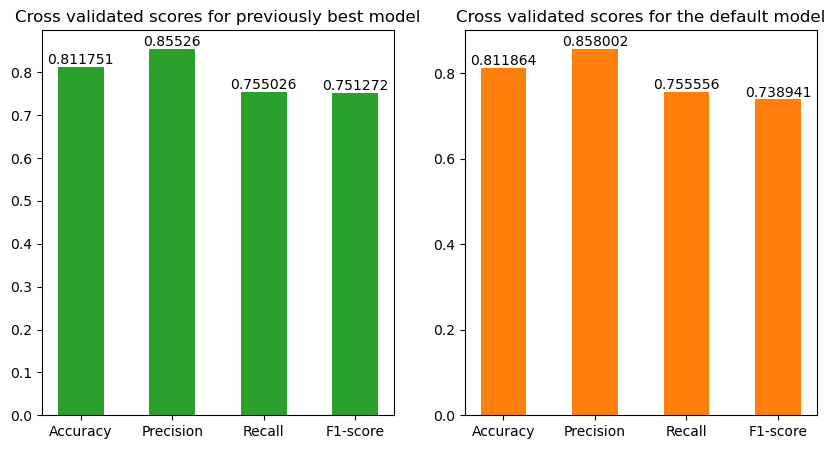

In [105]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

ax1.bar(x=final_lr_metrics.columns, height=final_lr_metrics.values[0], color="tab:green", width=0.5,)
ax1.set_title("Cross validated scores for previously best model")
for container in ax1.containers:
    ax1.bar_label(container)

ax2.bar(x=cv_lr_scores["Default model"].columns, height=cv_lr_scores["Default model"].values[0], color="tab:orange", width=0.5)
ax2.set_title("Cross validated scores for the default model")
for container in ax2.containers:
    ax2.bar_label(container)

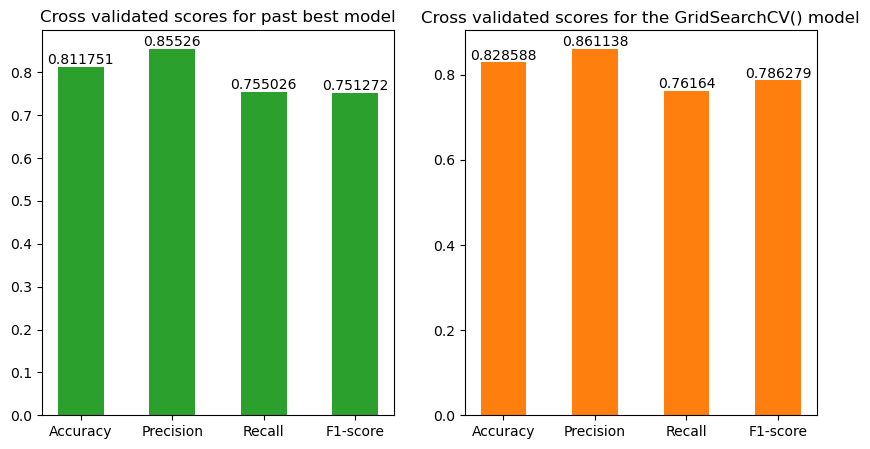

In [106]:
# As we can see the model with previously best settings did slightly better than the default model. 
# Let's compare it to the GridSearchCV one and see which did better

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

ax1.bar(x=final_lr_metrics.columns, height=final_lr_metrics.values[0], color="tab:green", width=0.5,)
ax1.set_title("Cross validated scores for past best model")
for container in ax1.containers:
    ax1.bar_label(container)

ax2.bar(x=cv_lr_scores["GridSearchCV model"].columns, height=cv_lr_scores["GridSearchCV model"].values[0], color="tab:orange", width=0.5)
ax2.set_title("Cross validated scores for the GridSearchCV() model")
for container in ax2.containers:
    ax2.bar_label(container)

In [107]:
# Since the GridSearchCV() model did better we will export this one as the final version

final_lr_clf = lr_grid_clf
final_lr_clf.fit(log_reg_X_train, log_reg_y_train)
import joblib

joblib.dump(final_lr_clf, "./underperforming_LogisticRegression.joblib")

['./underperforming_LogisticRegression.joblib']

As a little addendum let's just check how are the features correlating this time - further elimination might not be the best idea, but it will be nice to see if there's any significant change in the behaviour of the model and the given data

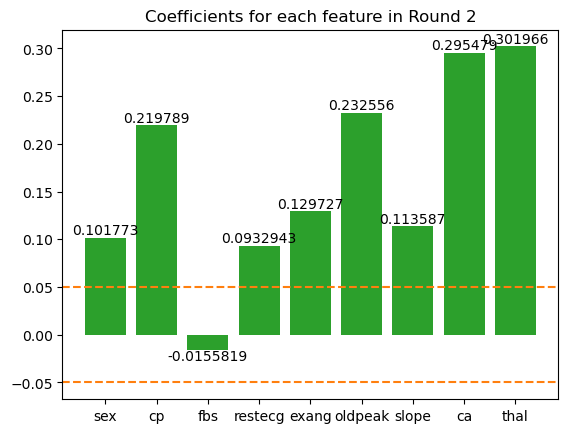

In [108]:
fig, ax = plt.subplots()
ax.bar(x=log_reg_X.columns, height=final_lr_clf.coef_[0], color="tab:green")
ax.set_title("Coefficients for each feature in Round 2")
ax.axhline(y=0.05, linestyle="--", color="tab:orange")
ax.axhline(y= -0.05, linestyle="--", color="tab:orange")
for container in ax.containers:
    ax.bar_label(container)


As we can see here removing few features at the start of this round resulted in a model, that uses given data at its fullest potential, except for just one feature. Off to Round 3

# Round 3 - `RandomForestClassifier()`

Let's begin this round similarily to the previous one - we will create a new DataFrame and then eliminate the feature columns that seemed to be the least important for the model in Round 1. To quote our previous conclusions:

    "Drop the columns with the lowest importance (fbs, restecg) and think about how we should treat the features that barely made it above the cutoff value (trestbps, chol)"

In [113]:
# We drop the unwanted features from our data set, then we check to see if it worked correctly. 
# Once again, we have to add this bit of code to make sure it works on our machines AND on Kaggle
try:
    df_rand_for = pd.read_csv("heart_cleveland_upload.csv")
except:
    df_rand_for = pd.read_csv("/kaggle/input/heart-disease-cleveland-uci/heart_cleveland_upload.csv")

df_rand_for.drop(["trestbps", "chol"], axis=1, inplace=True)
df_rand_for.rename(columns={"condition":"target"}, inplace=True)

In [114]:
df_rand_for.head()

,age,sex,cp,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,69,1,0,1,2,131,0,0.1,1,1,0,0
1,69,0,0,0,0,151,0,1.8,0,2,0,0
2,66,0,0,0,0,114,0,2.6,2,0,0,0
3,65,1,0,1,2,174,0,1.4,1,1,0,1
4,64,1,0,0,2,144,1,1.8,1,0,0,0


In [133]:
# Let's now divide the data into X and y
rand_for_X = df_rand_for.drop(["target"], axis=1)
rand_for_y = df_rand_for["target"]

# Let's split data into train and test sets
np.random.seed(31)
rand_for_X_train, rand_for_X_test, rand_for_y_train, rand_for_y_test = train_test_split(rand_for_X, rand_for_y, test_size=0.2)

In [134]:
# As we did previously, it's time to instantiate, train and score a new RandomForestClassifier() model

rand_for_model = RandomForestClassifier()
rand_for_model.fit(rand_for_X_train, rand_for_y_train)
rand_for_model.score(rand_for_X_test, rand_for_y_test)

0.8666666666666667

With a new random seed the model performs at a quite high standard of about 87%. 

Now it's time to search witch hyperparameters are best tuned for enhanced performance and see both how long it takes to find them via `RandomizedSearchCV()` and `GridSearchCV()`. Off to the documentation!

In [196]:
max_depth_list = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth_list.append(None)

rand_for_param_grid = {
    "n_estimators": range(20, 200, 10),
    "max_features" : ['sqrt', 'log2', None],
    "max_depth": max_depth_list,
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"],
    "oob_score": [True, False],
    "warm_start": [True, False]

}

In [197]:
np.random.seed(31)

randsearch_rand_for = RandomizedSearchCV(
    estimator= RandomForestClassifier(),
    param_distributions= rand_for_param_grid,
    cv= 5,
    n_iter= 100,
    verbose= True
)

randsearch_rand_for.fit(rand_for_X_train, rand_for_y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/aleksanderciesielski/opt/miniconda3/envs/ML-env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
110 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
110 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/aleksanderciesielski/opt/miniconda3/envs/ML-env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/aleksanderciesielski/opt/miniconda3/envs/ML-env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 437, in fit
    raise ValueError("Out of bag estimation only available if bootstrap=True")
ValueEr

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': range(20, 200, 10),
                                        'oob_score': [True, False],
                                        'warm_start': [True, False]},
                   verbose=True)

In [198]:
randsearch_rand_for.score(rand_for_X_test, rand_for_y_test)

0.8833333333333333

In [199]:
#As we can see, this model did better than the default one in terms of accuracy. Let's see the chosen hyperparameters
randsearch_rand_for.best_params_

{'warm_start': False,
 'oob_score': True,
 'n_estimators': 140,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 40,
 'criterion': 'entropy',
 'bootstrap': True}

Now that we can see the best hyperparameters found by `RandomizedSearchCV()` let's get to creating a new hyperparameter grid for `GridSearchCV()`

In [243]:
rand_for_param_grid_2 = {
    "n_estimators": [120, 140, 200, 245, 300],
    "max_features" : ['sqrt', 'log2'],
    "max_depth": [40, 42, 50],
    "min_samples_split": range(10, 22, 3),
    "min_samples_leaf": range(2, 18, 3),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"],
    "oob_score": [True, False],
    "warm_start": [False]
}

In [244]:
gridsearch_rand_for = GridSearchCV(
    estimator= RandomForestClassifier(),
    param_grid= rand_for_param_grid_2,
    cv= 5,
    verbose= True,
)

gridsearch_rand_for.fit(rand_for_X_train, rand_for_y_train)

Fitting 5 folds for each of 5760 candidates, totalling 28800 fits


/Users/aleksanderciesielski/opt/miniconda3/envs/ML-env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
7200 fits failed out of a total of 28800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/aleksanderciesielski/opt/miniconda3/envs/ML-env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/aleksanderciesielski/opt/miniconda3/envs/ML-env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 437, in fit
    raise ValueError("Out of bag estimation only available if bootstrap=True")
Val

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [40, 42, 50],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': range(2, 18, 3),
                         'min_samples_split': range(10, 22, 3),
                         'n_estimators': [120, 140, 200, 245, 300],
                         'oob_score': [True, False], 'warm_start': [False]},
             verbose=True)

In [245]:
gridsearch_rand_for.score(rand_for_X_test, rand_for_y_test)

0.85

In [252]:
# So the GridSearchCV model did worse. 
# Now let's get it's best parameters and then put them, and RandomizedSearchCV's best parameters into a dict of sets
gridsearch_rand_for.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 42,
 'max_features': 'log2',
 'min_samples_leaf': 11,
 'min_samples_split': 13,
 'n_estimators': 245,
 'oob_score': True,
 'warm_start': False}

In [251]:
difference_dict = {}

for param in gridsearch_rand_for.best_params_.keys():
    difference_dict[param] = []

for param, value in randsearch_rand_for.best_params_.items():
    difference_dict[param].append(value)
for param, value in gridsearch_rand_for.best_params_.items():
    difference_dict[param].append(value)

for param in difference_dict.keys():
    difference_dict[param] = set(difference_dict[param])

# Now we will see which values were the same and which were different between both models
# This will allow us to do one final GridSearchCV() later on...
difference_dict

{'bootstrap': {True},
 'criterion': {'entropy', 'gini'},
 'max_depth': {40, 42},
 'max_features': {'log2'},
 'min_samples_leaf': {2, 11},
 'min_samples_split': {10, 13},
 'n_estimators': {140, 245},
 'oob_score': {True},
 'warm_start': {False}}

Now let's see how the models did - it's evaluation time. Let's remind ourselves which metrics are we going to do:

- ROC Curve and AUC score
- Confusion matrix
- Classification report
- Precision
- Recall
- F1-score



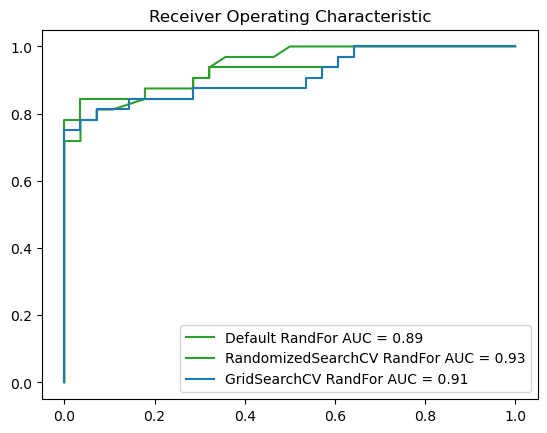

In [257]:
evaluated_rand_fors = {
    "Default model": rand_for_model,
    "RandomizedSearchCV model": randsearch_rand_for,
    "GridSearchCV model": gridsearch_rand_for
}

rf_def_fpr, rf_def_tpr, rf_def_threshold = roc_curve(rand_for_y_test, evaluated_rand_fors["Default model"].predict_proba(rand_for_X_test)[::,1])
rf_rand_fpr, rf_rand_tpr, rf_rand_threshold = roc_curve(rand_for_y_test, evaluated_rand_fors["RandomizedSearchCV model"].predict_proba(rand_for_X_test)[::,1])
rf_grid_fpr, rf_grid_tpr, rf_grid_threshold = roc_curve(rand_for_y_test, evaluated_rand_fors["GridSearchCV model"].predict_proba(rand_for_X_test)[::,1])

rf_def_auc = auc(rf_def_fpr, rf_def_tpr)
rf_rand_auc = auc(rf_rand_fpr, rf_rand_tpr)
rf_grid_auc = auc(rf_grid_fpr, rf_grid_tpr)

fig, ax = plt.subplots()
plt.title("Receiver Operating Characteristic")
plt.plot(rf_def_fpr, rf_def_tpr, label="Default RandFor AUC = %0.2f" % lr_def_auc, color="tab:green")
plt.plot(rf_rand_fpr, rf_rand_tpr, label="RandomizedSearchCV RandFor AUC = %0.2f" % rf_rand_auc, color="tab:green")
plt.plot(rf_grid_fpr, rf_grid_tpr, label="GridSearchCV RandFor AUC = %0.2f" % rf_grid_auc, color= "tab:blue")
plt.legend(loc="lower right")

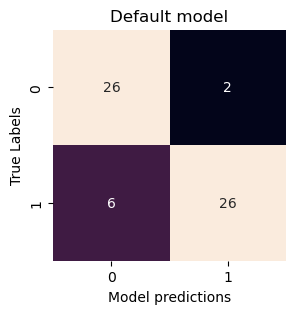

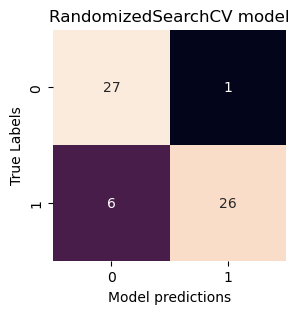

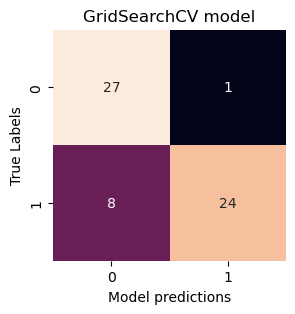

In [258]:
for name, model in evaluated_rand_fors.items():
    plot_conf_mat(
        y_test= rand_for_y_test,
        y_preds= model.predict(rand_for_X_test),
        name= name
    )

In [260]:
# Now for the classification reports

for name, model in evaluated_rand_fors.items():
    print(f"Classification report for {name}")
    print(classification_report(rand_for_y_test, model.predict(rand_for_X_test)))

Classification report for Default model
              precision    recall  f1-score   support

           0       0.81      0.93      0.87        28
           1       0.93      0.81      0.87        32

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60

Classification report for RandomizedSearchCV model
              precision    recall  f1-score   support

           0       0.82      0.96      0.89        28
           1       0.96      0.81      0.88        32

    accuracy                           0.88        60
   macro avg       0.89      0.89      0.88        60
weighted avg       0.90      0.88      0.88        60

Classification report for GridSearchCV model
              precision    recall  f1-score   support

           0       0.77      0.96      0.86        28
           1       0.96      0.75      0.84        32

    accuracy                           0.85   

In [261]:
# Again we will recreate the models from scratch with the best hyperparameters from each search and cross validate them

rf_def_clf = RandomForestClassifier()

rf_rand_clf = RandomForestClassifier(
    bootstrap= True,
    criterion= 'entropy',
    max_depth= 40,
    max_features= 'log2',
    min_samples_leaf= 2,
    min_samples_split= 10,
    n_estimators= 140, 
    oob_score= True,
    warm_start= False, 
)

rf_grid_clf = RandomForestClassifier(
    bootstrap= True,
    criterion= 'gini',
    max_depth= 42,
    max_features= 'log2',
    min_samples_leaf= 11,
    min_samples_split= 13,
    n_estimators= 245,
    oob_score= True,
    warm_start= False
)

cv_rand_for = {
    "Default model": rf_def_clf,
    "RandomizedSearchCV model": rf_rand_clf,
    "GridSearchCV model": rf_grid_clf
}

In [272]:
cv_rf_scores = {}
for name, model in cv_rand_for.items():
    cv_rf_scores[name] = cross_val_metrics(model, rand_for_X, rand_for_y)

In [273]:
cv_rf_scores

{'Default model':    Accuracy  Precision    Recall  F1-score
 0  0.713785   0.804174  0.726984  0.686064,
 'RandomizedSearchCV model':    Accuracy  Precision    Recall  F1-score
 0  0.744294   0.811359  0.748942  0.695787,
 'GridSearchCV model':    Accuracy  Precision    Recall  F1-score
 0   0.77791   0.837956  0.762963  0.724578}

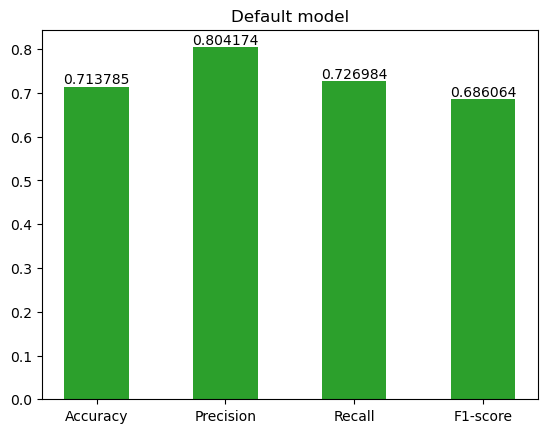

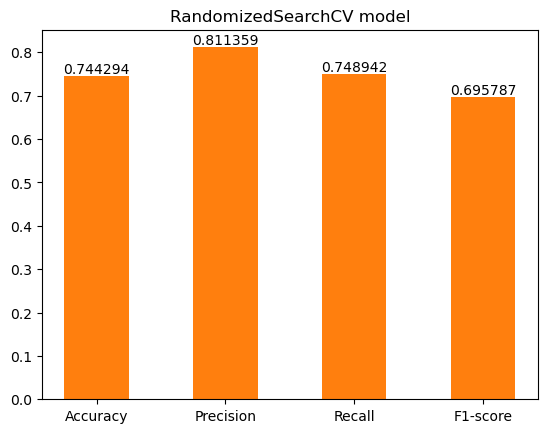

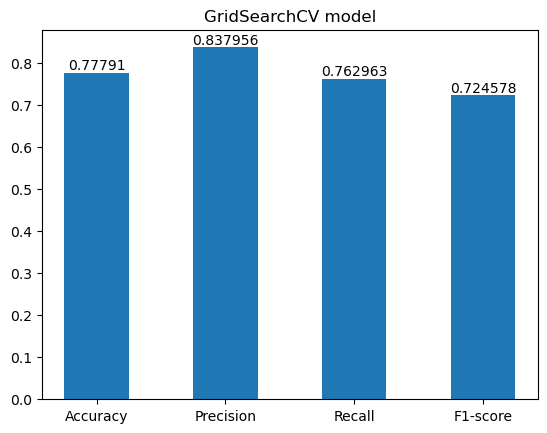

In [274]:
idx = 0
for name, score in cv_rf_scores.items():
    fig, ax = plt.subplots()
    ax.bar(
        x= score.columns,
        height= score.values[0],
        width= 0.5,
        color= colors[idx]
    )
    for container in ax.containers:
        ax.bar_label(container)
    ax.set_title(name)
    idx += 1
    

Looking at these bars I believe we can conclude that the `GridSearchCV()` model is the least overfitted of all the models and should most likely be the one to consider exporting. 

Let's do one final `GridSearchCV()` and see if the differences between `RandomizedSearchCV()` and current `GridSearchCV()` models make any actual difference

In [276]:
for name, value in difference_dict.items():
    difference_dict[name] = list(value)

final_rand_for = GridSearchCV(
    estimator= RandomForestClassifier(),
    param_grid= difference_dict,
    cv= 5,
    verbose= True
)

final_rand_for.fit(rand_for_X_train, rand_for_y_train)
final_rand_for.score(rand_for_X_test, rand_for_y_test)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


0.8833333333333333

In [277]:
# We got a high score on a specified test set, let's see the best parameters and then do cross-validated metrics
final_rand_for.best_params_ 

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 40,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 140,
 'oob_score': True,
 'warm_start': False}

In [322]:
rand_for_parameters = pd.DataFrame.from_dict(final_rand_for.best_params_, orient="index")
rand_for_parameters.rename(columns={0: "Final model"}, inplace=True)
rand_for_parameters["RandomizedSearchCV"] = pd.DataFrame.from_dict(randsearch_rand_for.best_params_, orient="index")
rand_for_parameters["GridSearchCV"] = pd.DataFrame.from_dict(gridsearch_rand_for.best_params_, orient="index")


In [323]:
rand_for_parameters

,Final model,RandomizedSearchCV,GridSearchCV
bootstrap,True,True,True
criterion,entropy,entropy,gini
max_depth,40,40,42
max_features,log2,log2,log2
min_samples_leaf,2,2,11
min_samples_split,10,10,13
n_estimators,140,140,245
oob_score,True,True,True
warm_start,False,False,False


This DataFrame shows us, that out of all possible matches between the different values in `RandomizedSearchCV()` and `GridSearchCV` the final model is tuned exactly as the `RandomizedSearchCV()` one. I doubt there's any reason to run the cross-validation on it since the results will most likely be the same. Still as two final things we will see the coefficients of the features and then export the `GridSearchCV` model since it did best in cross-validation

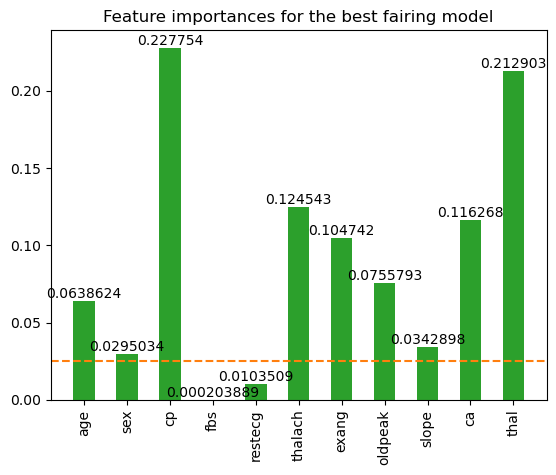

In [343]:
rf_grid_clf.fit(rand_for_X_train, rand_for_y_train)
fig, ax = plt.subplots()
ax.bar(
    x= rand_for_X_train.columns,
    height= rf_grid_clf.feature_importances_,
    width= 0.5,
    color= "tab:green"
) 
for container in ax.containers:
    ax.bar_label(container)
ax.set_title("Feature importances for the best fairing model")
ax.axhline(y=0.025, linestyle="--", color="tab:orange")
plt.xticks(rotation=90);

We can see that two more features could possible be removed to improve model's performance. For now that's about it, let's export the model and leave this notebook for now

In [344]:
joblib.dump(rf_grid_clf, filename="./underperforming_RandomForestClassifier.joblib")

['./underperforming_RandomForestClassifier.joblib']

# Final thoughts (for now at least)

I think it's time to put this project aside for now. I did not reach my goal, but we got kind of close a few time to a equally satisfying 90%. What I wanted to take out from this project was the understanding of how the models differ and overfit themselves when using `train_test_split` data and THEN putting them through cross-validation. It turned out that tuning hyperparameters is a form of art that is quite difficult to master, if you want to get actually better results.

If I ever return to this notebook I might consider putting the data through CatBoost and maybe XGBoost to see if these libraries improve my results. But for now, thank you to everyone following this notebook either on GitHub or on Kaggle. Please leave any comments since I want to improve my very, very limited knowledge of the topic and work on my skills.

### See you round!